# Read the network

In [1]:
import networkx as nx
from networkx.algorithms.centrality import *
import numpy as np
import matplotlib.pyplot as plt
import operator
from math import sqrt

In [2]:
import pandas as pd
df = pd.read_csv(r".\collins_yeast\edges.csv")
df.head()

,# source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [3]:
df = df.iloc[:, 0:2]
df.rename(columns={'# source':'s', ' target':'t'}, inplace=True)
df

,s,t
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
9065,1611,1612
9066,1614,1615
9067,1617,68
9068,1618,797


In [4]:
# Convert network to a graph
g = nx.from_pandas_edgelist(df, source='s', target='t')
print(nx.info(g))

Graph with 1622 nodes and 9070 edges


# Check connectedness

In [5]:
nx.is_connected(g)

False

In [6]:
nx.number_connected_components(g)

193

# Get LCC if graph is disconnected

In [7]:
g_lcc = nx.Graph() 

if nx.is_connected(g) == False: 
    largestComponents = [g.subgraph(c).copy() for c in sorted(nx.connected_components(g), key=len, reverse=True)] 
    print(nx.info(largestComponents[0]))
g_lcc=largestComponents[0] 
g = g_lcc

Graph with 1004 nodes and 8319 edges


# Relabel nodes for consistency in centrality calculation

In [8]:
from myTruss import mappingAndRelabeling

In [9]:
g_relabled = mappingAndRelabeling(g)

In [10]:
g = g_relabled

# Getting Community Structure According to Infomap

In [11]:
import community
import infomap

In [12]:
im = infomap.Infomap("--two-level")

print("Building Infomap network from a NetworkX graph...")
for source, target in g.edges:
    im.add_link(source, target)

print("Find communities with Infomap...")
im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

communities = im.get_modules()

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 61 modules with codelength: 6.238597624435166


In [13]:
modularity_value = community.modularity(communities, g)
modularity_value

0.7460726571592791

In [14]:
from organizeCommunities import *

In [15]:
# Input: dictionary of keys as nodes and values as community number
# Output: dictionary of keys as community number and values as nodes in that community
def flip_nodes_and_communities(dict_nodes_communities):
    # Step 1: initialize communities as keys
    new_dict = {}
    for k, v in dict_nodes_communities.items():
        new_dict[v]=[]
    
    # Step 2: Fill in nodes
    for kk,vv in new_dict.items():
        for k,v in dict_nodes_communities.items():
            if dict_nodes_communities[k] == kk:
                new_dict[kk].append(k)
    
    return new_dict

In [16]:
# Step 1
infomap_communities = flip_nodes_and_communities(communities)

In [17]:
# Step 2
infomap_communities_organized = orderCommunities(infomap_communities)

In [18]:
communityInfo(infomap_communities, infomap_communities_organized)

Number of partitions:  61
Number of nodes in the communities detected:  1004
Number of repetitions:  0




In [19]:
from graphsExtractor import *
from methods_overlapping import *

In [20]:
lo, membership_all_nodes, membership_overlapping_nodes = list_overlapping(g, infomap_communities_organized)
g_wo, dict_graph_wo, partition_wo = remove_overlapping(g, lo, infomap_communities_organized)
g_intra_wo, graph_wo_intra = intra_wo(dict_graph_wo, infomap_communities_organized)
g_inter, graph_inter = inter_wo_o(g, infomap_communities_organized)

In [21]:
number_of_intra_components = nx.number_connected_components(graph_wo_intra)
largestComponents = [graph_wo_intra.subgraph(c).copy() for c in sorted(nx.connected_components(graph_wo_intra), key=len, reverse=True)]

In [22]:
total_nodes = 0
total_edges = 0
for i in range(number_of_intra_components): # for each communtiy
    total_nodes = total_nodes + len(largestComponents[i].nodes())
    total_edges = total_edges + len(largestComponents[i].edges())

In [23]:
total_nodes

1004

In [24]:
total_edges # Same as total nodes and edges of graph_wo_intra

7294

In [25]:
nx.info(graph_wo_intra)

'Graph with 1004 nodes and 7294 edges'

In [26]:
dict_graph = dict()
for i in g:
    dict_graph[i] = []
    for j in g[i]:
        dict_graph[i].append(j)

In [27]:
print('Raw graph information:')
print(nx.info(g))

Raw graph information:
Graph with 1004 nodes and 8319 edges


In [28]:
# Convert the different dictionaries into graphs to be for calculation of different centralities
g_intra_wo_converted = nx.Graph(g_intra_wo)
g_inter_converted = nx.Graph(g_inter)
dict_graph_converted = nx.Graph(dict_graph)
listofnodes = list(dict_graph_converted.nodes())

# Helper functions

In [29]:
import collections
import heapq
import operator
import scipy.stats as stats

# Returns a list of the top_k nodes and their centralities, and heap (list) of top k nodes --> heap will be used for removal
def get_top_k_best_nodes(dict_centrality, k):
    
    # The sorted() function returns a sorted list of the specified iterable object
    top_k = sorted(dict_centrality.items(), key=operator.itemgetter(1), reverse=True)[:k]
    first_nodes = heapq.nlargest(k, dict_centrality, key=dict_centrality.get)
    
    return top_k, first_nodes

In [30]:
# Returns a list of the bottom_k nodes and their centralities, and heap (list) of top k nodes --> heap will be used for removal
def get_bottom_k_best_nodes(dict_centrality, k):
    
    # The sorted() function returns a sorted list of the specified iterable object
    bottom_k = sorted(dict_centrality.items(), key=operator.itemgetter(1))[:k]
    bottom_nodes = heapq.nsmallest(k, dict_centrality, key=dict_centrality.get)
    
    return bottom_k, bottom_nodes

# Community-aware ranking scheme
## Sort the communities by size

Sort the communities by size from largest to smallest: `dict_nodes_community_x` is a dictionary where community:[nodes] with communities sorted from from biggest to smallest through "largestComponents"

In [31]:
dict_nodes_community_x = {}
for i in range(number_of_intra_components): # Number of communities
    dict_nodes_community_x[i] = []
    for node in largestComponents[i].nodes():
        dict_nodes_community_x[i].append(node)
print(dict_nodes_community_x)

{0: [120, 123, 127, 130, 132, 135, 136, 137, 138, 139, 140, 141, 145, 146, 148, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 196, 197, 198, 199, 201, 202, 203, 204, 208, 243, 244, 245, 247, 249, 251, 252, 255, 258, 259, 260, 280, 281, 282, 284, 285, 286, 287, 288, 289, 290, 291, 341, 342, 343, 344, 860, 861, 680, 681, 373, 386, 910, 399, 403, 409, 446, 447, 448, 449, 450, 451, 453, 454, 455, 456, 457, 458, 460, 461, 464, 467, 994, 998], 1: [652, 419, 420, 421, 422, 549, 424, 425, 426, 427, 428, 423, 429, 430, 431, 433, 434, 432, 436, 437, 435, 438, 699, 700, 701, 702, 445, 960, 323, 837, 76, 77, 78, 79, 80, 81, 978, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 987, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 991], 2: [256, 257, 261, 134, 263, 646, 265, 262, 267, 266

## Function to return the nodes to be infected/immunized iterating community by community from largest to smallest

In [32]:
def getTopCommunityNodes(dict_nodes_community_x_sorted, stop_at_list):
    y_top_degree = []
    for p in fraction:   
        percentage_to_infect = round(p*network_size)
        counter = 0
        while (percentage_to_infect != counter):
            for com, list_nodes_ in dict_nodes_community_x_sorted.items(): # For each community and its nodes
                list_temp = []
                for i in list_nodes_:
                    list_temp.append(i)
                if (len(list_temp) == 0):
                    continue
                x_temp = list_temp.pop(0) # Get the top node
                y_top_degree.append(x_temp)
                counter = counter + 1 
                print("counter", counter)
                if (counter == max(stop_at_list)): 
                    print("DONE")
                    return y_top_degree
            for i in y_top_degree:
                for key_com, nodes_list in dict_nodes_community_x_sorted.items():
                    for node in nodes_list:
                        if node == i:
                            dict_nodes_community_x_sorted[key_com].remove(node)     

## Function to sort nodes inside the sorted communities based on any centrality

In [33]:
def sortNodesInsideCommunities(dict_nodes_community_x, dict_centrality):
    dict_nodes_community_x_sorted = {}
    for com, list_nodes in dict_nodes_community_x.items():
        nodes_community_x_sorted = sorted(list_nodes, key=lambda x: dict_centrality[x], reverse=True)
        dict_nodes_community_x_sorted[com] = nodes_community_x_sorted
    return dict_nodes_community_x_sorted

# Degree centrality #1

## Original Ranking

In [34]:
dict_degree = nx.degree_centrality(g)

In [35]:
dict_degree[1]

0.0009970089730807576

### Plot at low fraction 
$f_o = 1\%$ (or 10 nodes minimum)

In [36]:
network_size = len(g.nodes())
network_size

1004

In [37]:
low_fraction = round(network_size*0.01)
if low_fraction < 10:
    low_fraction = 10
low_fraction

10

In [38]:
x, y = get_top_k_best_nodes(dict_degree, network_size)
x[0]

(146, 0.12662013958125623)

In [39]:
dict_degree_sorted = dict(sorted(dict_degree.items(), key=operator.itemgetter(1), reverse=True))

In [40]:
x, y = get_top_k_best_nodes(dict_degree_sorted, network_size)
y_top_10 = y[:low_fraction]
len(y_top_10)

10

In [41]:
print(y_top_10)

[146, 197, 204, 198, 141, 171, 188, 120, 181, 186]


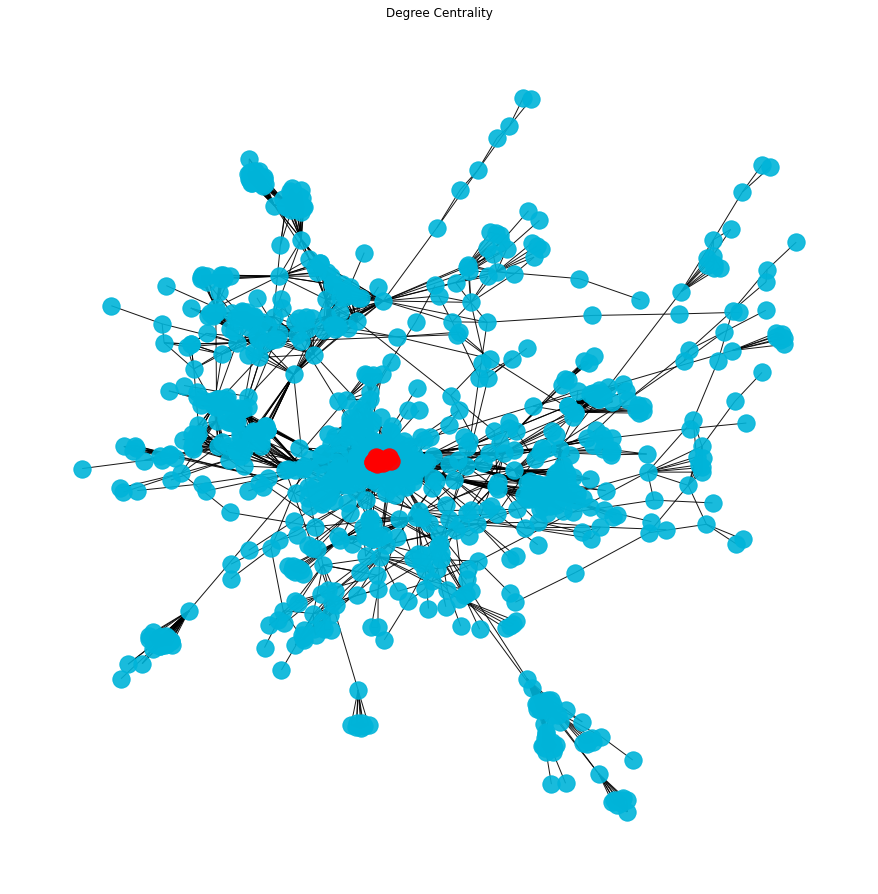

In [42]:
pos = nx.spring_layout(g, seed=123)
plt.figure(3,figsize=(12,12)) 
nx.draw(g,pos, alpha=0.9, node_color='#00b4d9')
for i in y_top_10:
    nx.draw_networkx_nodes(g, pos, nodelist=[i], node_color='r', alpha=0.95, label=str(i))
plt.title("Degree Centrality")
plt.show()

### Plot at high fraction 
$f_o = 15\%$

In [43]:
network_size = len(g.nodes())
network_size

1004

In [44]:
low_fraction = round(network_size*0.15)
if low_fraction < 10:
    low_fraction = 10
low_fraction

151

In [45]:
x, y = get_top_k_best_nodes(dict_degree, network_size)
x[0]

(146, 0.12662013958125623)

In [46]:
dict_degree_sorted = dict(sorted(dict_degree.items(), key=operator.itemgetter(1), reverse=True))

In [47]:
x, y = get_top_k_best_nodes(dict_degree_sorted, network_size)
y_top_x = y[:low_fraction]
len(y_top_x)

151

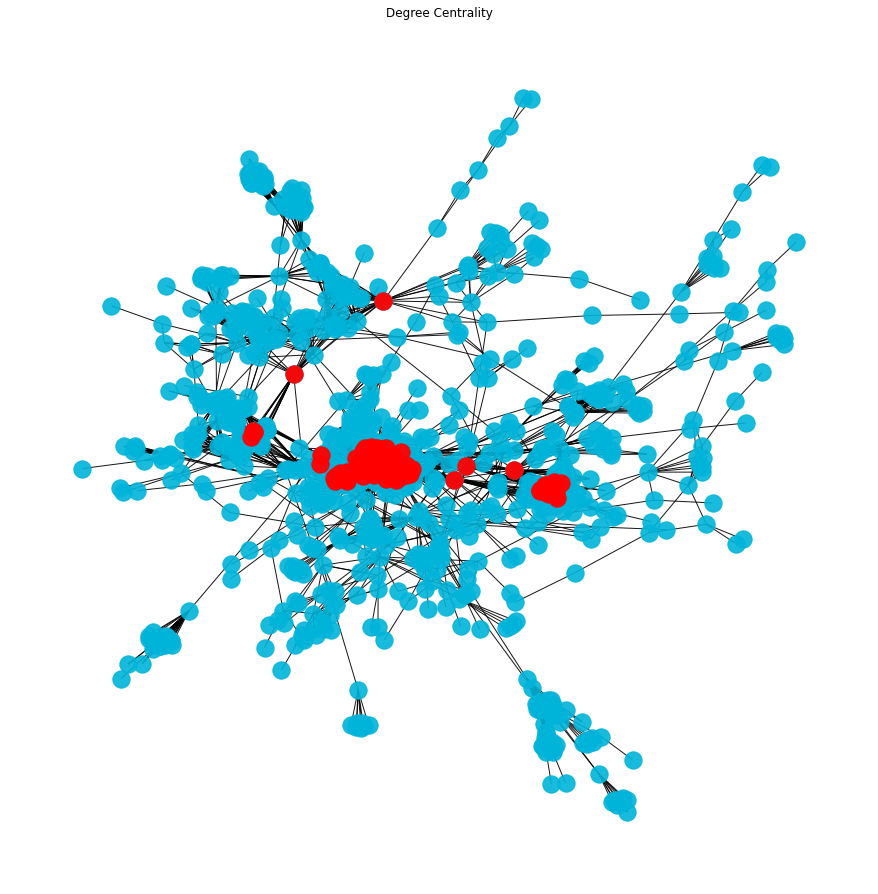

In [48]:
pos = nx.spring_layout(g, seed=123)
plt.figure(3,figsize=(12,12)) 
nx.draw(g,pos, alpha=0.9, node_color='#00b4d9')
for i in y_top_x:
    nx.draw_networkx_nodes(g, pos, nodelist=[i], node_color='r', alpha=0.95, label=str(i))
plt.title("Degree Centrality")
plt.show()

## Community-aware Ranking

In [49]:
fraction = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,0.21,
           0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40,
           0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50]

In [50]:
stop_at_list = []
for p in fraction:   
    percentage_to_infect = round(p*network_size)
    stop_at_list.append(percentage_to_infect)
print(max(stop_at_list))

502


In [51]:
dict_nodes_community_x_sorted = sortNodesInsideCommunities(dict_nodes_community_x, dict_degree)
print(dict_nodes_community_x_sorted)

{0: [146, 197, 204, 198, 141, 171, 188, 120, 181, 186, 386, 167, 163, 130, 162, 140, 185, 136, 157, 190, 139, 148, 165, 184, 150, 178, 179, 187, 153, 177, 127, 138, 155, 164, 137, 168, 145, 175, 182, 156, 170, 135, 123, 199, 158, 152, 169, 172, 203, 161, 173, 446, 132, 194, 159, 191, 176, 201, 160, 174, 183, 202, 260, 251, 447, 252, 286, 154, 166, 245, 244, 259, 247, 399, 280, 196, 342, 258, 249, 287, 448, 208, 282, 288, 285, 255, 456, 192, 289, 243, 341, 284, 281, 290, 455, 467, 681, 454, 409, 458, 449, 451, 291, 373, 403, 343, 680, 910, 344, 860, 861, 450, 453, 457, 460, 461, 464, 994, 998], 1: [83, 85, 426, 80, 103, 104, 88, 96, 420, 111, 98, 433, 90, 92, 110, 100, 109, 425, 87, 91, 105, 106, 419, 422, 86, 424, 93, 97, 107, 77, 102, 421, 427, 79, 81, 95, 101, 700, 114, 699, 112, 437, 701, 702, 76, 89, 108, 434, 435, 438, 323, 428, 423, 82, 99, 429, 837, 78, 549, 431, 432, 652, 84, 436, 115, 445, 430, 113, 960, 991, 978, 987, 116], 2: [189, 14, 257, 261, 134, 274, 235, 195, 265, 237,

In [52]:
X = getTopCommunityNodes(dict_nodes_community_x_sorted, stop_at_list)

counter 1
counter 2
counter 3
counter 4
counter 5
counter 6
counter 7
counter 8
counter 9
counter 10
counter 11
counter 12
counter 13
counter 14
counter 15
counter 16
counter 17
counter 18
counter 19
counter 20
counter 21
counter 22
counter 23
counter 24
counter 25
counter 26
counter 27
counter 28
counter 29
counter 30
counter 31
counter 32
counter 33
counter 34
counter 35
counter 36
counter 37
counter 38
counter 39
counter 40
counter 41
counter 42
counter 43
counter 44
counter 45
counter 46
counter 47
counter 48
counter 49
counter 50
counter 51
counter 52
counter 53
counter 54
counter 55
counter 56
counter 57
counter 58
counter 59
counter 60
counter 61
counter 62
counter 63
counter 64
counter 65
counter 66
counter 67
counter 68
counter 69
counter 70
counter 71
counter 72
counter 73
counter 74
counter 75
counter 76
counter 77
counter 78
counter 79
counter 80
counter 81
counter 82
counter 83
counter 84
counter 85
counter 86
counter 87
counter 88
counter 89
counter 90
counter 91
counter 

In [53]:
print(X)

[146, 83, 189, 129, 534, 619, 24, 5, 556, 487, 58, 812, 599, 664, 300, 466, 124, 633, 370, 505, 94, 118, 46, 336, 205, 852, 126, 346, 347, 754, 886, 463, 704, 310, 544, 882, 967, 227, 329, 396, 685, 896, 8, 692, 951, 817, 866, 65, 248, 268, 442, 530, 550, 459, 764, 802, 849, 402, 789, 822, 979, 197, 85, 14, 193, 712, 620, 17, 12, 564, 473, 68, 813, 595, 610, 297, 119, 826, 636, 414, 495, 394, 624, 44, 338, 206, 769, 128, 349, 355, 753, 908, 918, 703, 864, 539, 878, 970, 236, 316, 404, 686, 898, 2, 694, 952, 818, 869, 945, 916, 940, 683, 528, 551, 927, 763, 804, 850, 746, 973, 936, 980, 204, 426, 257, 200, 533, 376, 20, 13, 580, 474, 60, 520, 593, 657, 298, 644, 829, 654, 773, 506, 264, 626, 48, 334, 209, 853, 143, 345, 363, 755, 946, 919, 888, 867, 545, 879, 74, 279, 317, 397, 688, 897, 964, 695, 955, 819, 870, 944, 318, 986, 684, 527, 552, 926, 765, 999, 851, 198, 80, 261, 229, 734, 353, 23, 932, 560, 475, 57, 524, 605, 659, 295, 643, 324, 634, 350, 494, 395, 628, 49, 337, 913, 854, 1

### Plot at low fraction 
$f_o = 1\%$ (or 10 nodes minimum)

In [54]:
low_fraction = round(network_size*0.01)
if low_fraction < 10:
    low_fraction = 10
low_fraction

10

In [55]:
print(X[:40])

[146, 83, 189, 129, 534, 619, 24, 5, 556, 487, 58, 812, 599, 664, 300, 466, 124, 633, 370, 505, 94, 118, 46, 336, 205, 852, 126, 346, 347, 754, 886, 463, 704, 310, 544, 882, 967, 227, 329, 396]


In [56]:
print(X[:low_fraction])

[146, 83, 189, 129, 534, 619, 24, 5, 556, 487]


In [57]:
y_top_10 = X[:low_fraction]

In [58]:
len(y_top_10)

10

In [59]:
print(y_top_10)

[146, 83, 189, 129, 534, 619, 24, 5, 556, 487]


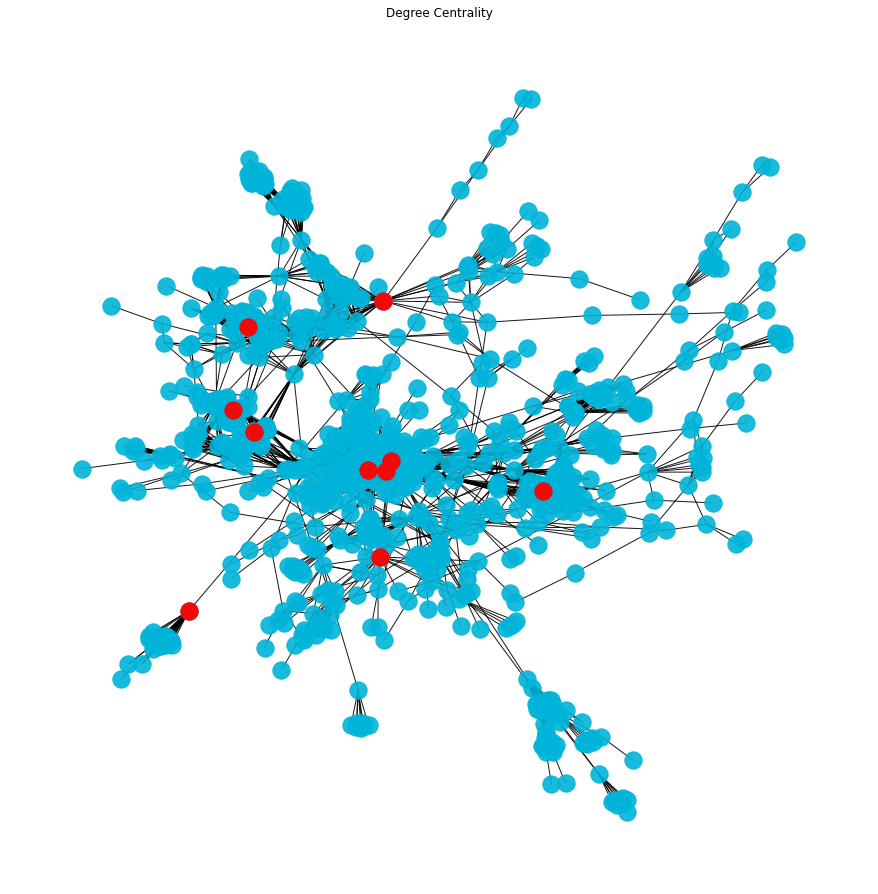

In [60]:
pos = nx.spring_layout(g, seed=123)
plt.figure(3,figsize=(12,12)) 
nx.draw(g,pos, alpha=0.9, node_color='#00b4d9')
for i in y_top_10:
    nx.draw_networkx_nodes(g, pos, nodelist=[i], node_color='r', alpha=0.95, label=str(i))
plt.title("Degree Centrality")
plt.show()

### Plot at high fraction 
$f_o = 15\%$

In [61]:
low_fraction = round(network_size*0.15)
if low_fraction < 10:
    low_fraction = 10
low_fraction

151

In [62]:
y_top_x = X[:low_fraction]

In [63]:
len(y_top_x)

151

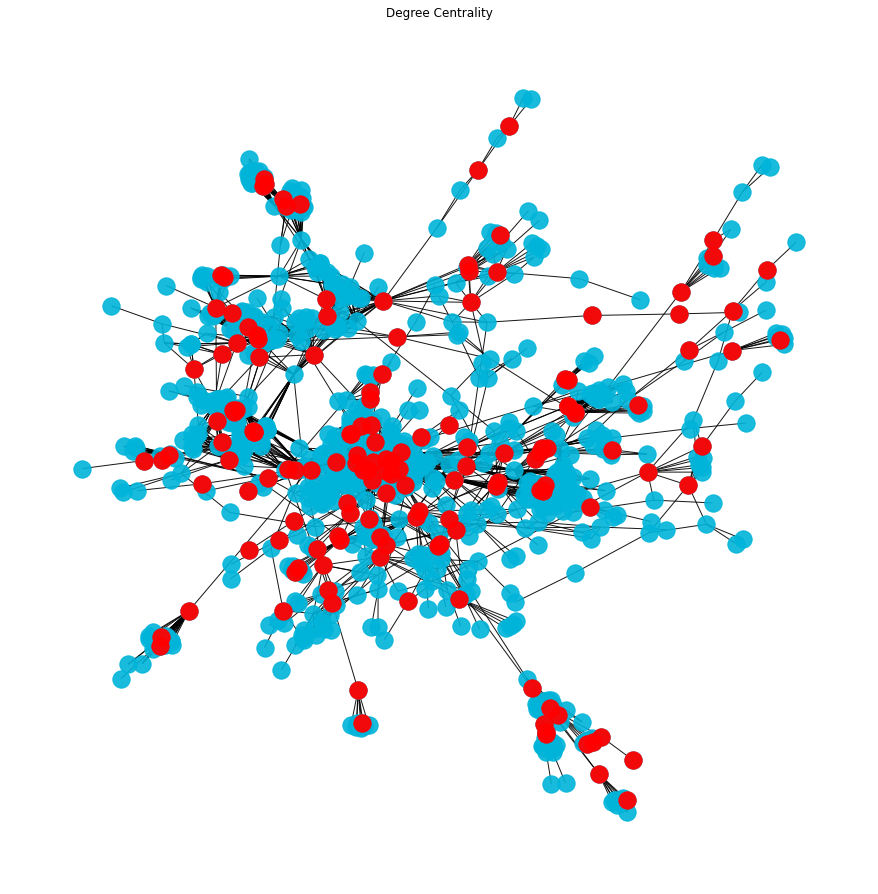

In [64]:
pos = nx.spring_layout(g, seed=123)
plt.figure(3,figsize=(12,12)) 
nx.draw(g,pos, alpha=0.9, node_color='#00b4d9')
for i in y_top_x:
    nx.draw_networkx_nodes(g, pos, nodelist=[i], node_color='r', alpha=0.95, label=str(i))
plt.title("Degree Centrality")
plt.show()